In [1]:
import numpy as np
import pandas as pd

import gurobipy as gp
from gurobipy import GRB
import time

import matplotlib.pyplot as plt

In [2]:
def get_data(data_path):
    df = pd.read_csv(data_path)
    y = df[['sepal_length', 'petal_length']].values
    z = df['species_label'].values
    return y, z

In [3]:
def plot_data_and_classifier(y, z, w, b, margin = True):
    
    # Plot data points
    plt.figure(figsize=(8, 6))
    plt.scatter(y[z == 1, 0], y[z == 1, 1], color='blue', label='Species 1')
    plt.scatter(y[z == -1, 0], y[z == -1, 1], color='red', label='Species 2')

    # Generate points for the classifier line and margins
    x_values = np.linspace(y[:, 0].min(), y[:, 0].max(), 100)
    
    # Plot the decision boundary
    y_decision_boundary = -(w[0] * x_values - b) / w[1]
    plt.plot(x_values, y_decision_boundary, 'k--', label='Decision Boundary')

    # Plot margins
    if margin:
        y_margin_positive = -(w[0] * x_values - b - 1) / w[1]  # w1*x1 + w2*x2 - b = 1
        y_margin_negative = -(w[0] * x_values - b + 1) / w[1]  # w1*x1 + w2*x2 - b = -1
        plt.plot(x_values, y_margin_positive, 'k-', label='Margin', linewidth=0.5)
        plt.plot(x_values, y_margin_negative, 'k-', linewidth=0.5)
    
    plt.xlabel('Sepal Length')
    plt.ylabel('Petal Length')
    plt.title('Flower Species Classification')
    plt.legend()
    plt.grid(True)
    plt.show()

In [4]:

def lp(data_path):
    y, z = get_data(data_path)
    n, d = y.shape
    m = gp.Model("lp")
    m.Params.LogToConsole = 0
    
    # Decision variables
    w = m.addVars(d, lb=-GRB.INFINITY, name="w")  # w1, w2
    b = m.addVar(lb=-GRB.INFINITY, name="b")      # b
    u = m.addVars(n, lb=0, name="u")              # hinge loss variables
    abs_w = m.addVars(d, lb=0, name="abs_w")      # auxiliary variables for |w|

    # Objective function
    m.setObjective(
        gp.quicksum(u[i] for i in range(n)) + (1/10) * gp.quicksum(abs_w[j] for j in range(d)),
        GRB.MINIMIZE
    )

    # Constraints
    for i in range(n):
        m.addConstr(
            u[i] >= 1 - z[i] * (gp.quicksum(w[j] * y[i, j] for j in range(d)) - b),
            name=f"hinge_loss_{i}"
        )

    # Constraints to model absolute values
    for j in range(d):
        m.addConstr(abs_w[j] >= w[j], name=f"abs_pos_{j}")
        m.addConstr(abs_w[j] >= -w[j], name=f"abs_neg_{j}")

    # Solve the LP
    m.optimize()

    # Extract variable values
    w_values = [w[j].X for j in range(d)]  # Extract w1, w2
    b_value = b.X                          # Extract b

    # Plot the data and classifier
    plot_data_and_classifier(y, z, w_values, b_value, margin=False)

    return w_values, b_value


Restricted license - for non-production use only - expires 2025-11-24


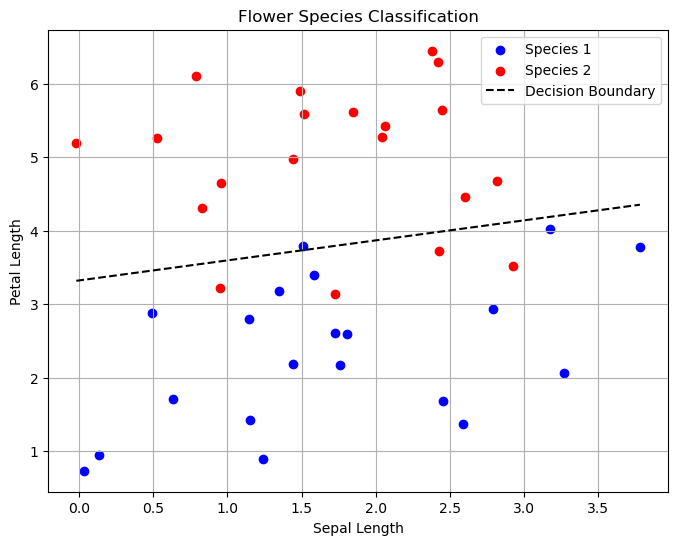

elapsed time  0.31854987144470215
Optimal w: [0.4697984822343964, -1.721956703756449], b: -5.721649852312391


In [5]:
if __name__ == "__main__":
    
    data_path = "/Users/arryankanodia/Downloads/flowers_data.csv"
    
    t = time.time()
    w_opt, b_opt = lp(data_path)
    elapsed = time.time() - t
    print("elapsed time ", elapsed)
    print(f"Optimal w: {w_opt}, b: {b_opt}")
    
    # t = time.time()
    # w_opt, b_opt = benders(data_path)
    # elapsed = time.time() - t
    # print("elapsed time ", elapsed)
    # print(f"Optimal w: {w_opt}, b: {b_opt}")